<a href="https://colab.research.google.com/github/cakennedy/266-mbti-project/blob/main/dataprep/Resampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W266 Final Project
# Resampling
# October 9, 2022
# John Clark, Shrinivas Joshi, Courtney Kennedy

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cakennedy/266-mbti-project/blob/main/notebooks/Resampling.ipynb#)


# There are several different resampling strategies to try

#### First, we want to look at using the four letter types as well as the categorical variables, and create new distributions by under and over sampling based on both ways of organizing the data.

#### Second, we want to try over/under sampling to get to different distributions.  These will include a uniform distribution across all categories and then a distribution that matches the natural distribution found in the general population.

In [6]:
# Google collab premium utilities status check
# GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print( '\n')

# RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Tue Jan 17 02:40:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    48W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# imports
import sys
import csv


import pandas as pd
import io
from io import BytesIO
import matplotlib.pyplot as plt
import altair as alt
import numpy as np
import textwrap

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.utils import resample
from sklearn.utils import shuffle


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
# Configuration Flags

useGCloudForStorage = True



In [9]:

# Global State Flags
uploadedGCloudCredentials = False
mountedGoogleDrive = False
configuredGCloud = False


# Global Variables
gdrive_path = '/content/drive/MyDrive/content/drive/'

gcloud_bucket = None
gcloud_bucket_name = ""

In [10]:
# To work from a google drive use this:
from google.colab import drive

def mount_google_drive():
    global userGCloudForStorage
    global mountedGoogleDrive

    if useGCloudForStorage == False:
        if mountedGoogleDrive == False:
            drive.mount('/content/drive')
            mountedGoogleDrive = True



In [11]:
# To work from gcloud, use this:

# Upload Google Cloud service account key to enable authentication ( json file )
# Go to https://console.cloud.google.com/:
# Under the Navigation Menu ( upper left 3 horizontal lines) 
# 1. choose IAM & Admin>
# 2. choose Service Accounts>
# 3. Select a Service Account>
# 4. Under the Actions menu ( 3 dots to the right of the service account )>Manage Keys to create your own json credentials file

from google.colab import files
from google.cloud import storage


def upload_gcloud_credentials():
    global useGCloudForStorage
    global uploadedGCloudCredentials

    if useGCloudForStorage:
        if uploadedGCloudCredentials == False:

            uploaded = files.upload()
            uploadedGCloudCredentials = True


def config_GCloud():
    global configuredGCloud
    global gcloud_bucket
    global gcloud_bucket_name

    if configuredGCloud:
        return gcloud_bucket, gcloud_bucket_name

    #Load Google Cloud storage client using service key
    storage_client = storage.Client.from_service_account_json('pacific-castle-360400-a3ca89f64de6.json')
    #Print buckets available
    for bucket in storage_client.list_buckets():
        print(bucket)

    #Assign bucket name being used
    gcloud_bucket_name = '266csffile'

    #Get bucket
    gcloud_bucket = storage_client.get_bucket(gcloud_bucket_name)

    #Show list of files in bucket and list the files
    filename = list(gcloud_bucket.list_blobs(prefix=''))
    for name in filename:
        print(name.name)

    #Increase field size to allow reading in of files
    maxInt = sys.maxsize

    while True:
        # decrease the maxInt value by factor 10 as long as overflow error occurs 
        try:
            csv.field_size_limit(maxInt)
            break
        except OverflowError:
            maxInt = int(maxInt/10)

    configuredGCloud = True

    return gcloud_bucket, gcloud_bucket_name


In [12]:
# Read source data files in and create dataframes

def read_sources_from_Drive():
    global useGCloudForStorage

    if useGCloudForStorage == True:  
        return

    mount_google_drive()

    # test file is a 1000 row file to use in developing data cleaning routines before tackling the real files
    # test_posts_df = pd.read_csv( '/content/drive/MyDrive/content/drive/test_posts.csv')

    # Two forms of Posts files- both a full dataframe and an iterator
    posts_full_df = pd.read_csv('/content/drive/MyDrive/content/drive/typology_xenforo-9-25-22-posts.csv')
    posts_iterator = pd.read_csv('/content/drive/MyDrive/content/drive/typology_xenforo-9-25-22-posts.csv', chunksize = 10000)

    header_df = pd.read_csv('/content/drive/MyDrive/content/drive/typology_xenforo.csv')

    return header_df, posts_full_df, posts_iterator


def read_sources_from_GCloud():
    global useGCloudForStorage

    if useGCloudForStorage == False:
        return

    upload_gcloud_credentials()
    bucket, bucket_name = config_GCloud()

    #Grab blob header file and download as string
    users = bucket.blob('typology_xenforo-9-25-22.csv')
    string_data_users = users.download_as_string()
    print( string_data_users )

    #Convert to pandas
    header_df = pd.read_csv(io.BytesIO(string_data_users), encoding='utf-8', sep=',', engine='python')

    #Grab blob posts file and download as string
    posts = bucket.blob('typology_xenforo-9-25-22-posts.csv')
    string_data_posts = posts.download_as_string()
    print( string_data_posts)

    #Convert to pandas
    posts_full_df = pd.read_csv(io.BytesIO(string_data_posts), encoding='utf-8', sep=',', engine='python')

    posts_iterator = pd.read_csv(io.BytesIO(string_data_posts), encoding='utf-8', sep=',', chunksize = 10000)

    return header_df, posts_full_df, posts_iterator



In [13]:
# write parquet files

def write_parquet_gdrive( df, filename):
    global gdrive_path

    full_path_to_file = gdrive_path + filename

    print( full_path_to_file)
    df.to_parquet(full_path_to_file)


def write_parquet_google_cloud( df, filename):

    bucket, bucket_name = config_GCloud()

    blob = bucket.blob( filename )
    blob.upload_from_string(df.to_parquet(), 'application/octet-stream')

def write_parquet_file( dataframe, filename):

    global useGCloudForStorage

    if useGCloudForStorage:
        write_parquet_google_cloud( dataframe, filename )
    else:
        write_parquet_gdrive( dataframe, filename )



In [14]:
# utility for writing a csv to our shared GCloud storage

def write_csv_file( dataframe, 
                    filename,
                    index,
                    header,
                    mode ):
    '''This function writes a panda to a CSV file in the Google cloud storage 
    bucket. Input parameters include the dataframe, the name of the file to 
    write, the index (write row names), header(create column names) and 
    mode(write) '''

    bucket, bucket_name = config_GCloud()
    blob = bucket.blob( filename )
    blob.upload_from_string(dataframe.to_csv(index=index, header=header, mode=mode), 'text/csv')



In [15]:
upload_gcloud_credentials()
bucket, bucket_name = config_GCloud()



Saving pacific-castle-360400-a3ca89f64de6.json to pacific-castle-360400-a3ca89f64de6 (1).json
<Bucket: 266csffile>
<Bucket: w266liwc>
dev_is_I_data.parquet
dev_is_I_labels.parquet
dev_is_J_data.parquet
dev_is_J_labels.parquet
dev_is_S_data.parquet
dev_is_S_labels.parquet
dev_is_T_data.parquet
dev_is_T_labels.parquet
dev_mbti_data.parquet
dev_mbti_labels.parquet
mrc2.dct.textClipping
old_files/
old_files/dev_mbti_data.csv
old_files/dev_mbti_data.parquet
old_files/dev_mbti_labels.csv
old_files/test_mbti_data.csv
old_files/test_mbti_data.parquet
old_files/test_mbti_labels.csv
old_files/train_gen_pop_mbti_data.csv
old_files/train_gen_pop_mbti_data.parquet
old_files/train_gen_pop_mbti_labels.csv
old_files/train_mbti_data.csv
old_files/train_mbti_data.parquet
old_files/train_mbti_labels.csv
old_files/train_over_sampled_mbti_data.csv
old_files/train_over_sampled_mbti_data.parquet
old_files/train_over_sampled_mbti_labels.csv
old_files/train_under_sampled_mbti_data.csv
old_files/train_under_sam

In [16]:
# read in the already cleaned posts data

posts_filename = 'typology_xenforo-9-25-22_clean.parquet'

print( posts_filename)

# read back and look for corruption
bucket, bucket_name = config_GCloud()

read_back = bucket.blob(posts_filename)
string_read_back = read_back.download_as_string()
posts_df = pd.read_parquet(io.BytesIO(string_read_back))




typology_xenforo-9-25-22_clean.parquet


In [17]:
# read in the already cleaned header(user) data

header_filename = 'typology_users_clean.csv'

bucket, bucket_name = config_GCloud()

header_blob = bucket.blob( header_filename )
header_string = header_blob.download_as_string()
   
users_df = pd.read_csv(io.BytesIO(header_string), engine='python')





In [18]:
def read_csv_from_gcloud( filename ):

    bucket, bucket_name = config_GCloud()

    blob = bucket.blob( filename )
    blob_string = blob.download_as_string()
    
    read_df = pd.read_csv(io.BytesIO(blob_string), engine='python')
    return read_df




In [19]:
def read_parquet_from_gcloud( filename ):

    bucket, bucket_name = config_GCloud()

    blob = bucket.blob( filename )
    blob_string = blob.download_as_string()
    
    read_df = pd.read_parquet(io.BytesIO(blob_string))
    return read_df





In [20]:
# read in the already cleaned, merged data

#Merge the post database and header database
merged_df = users_df.merge(posts_df, on='Username')


print("merged data shape:", merged_df.shape)
print( "merged data columns:", merged_df.columns )
print(merged_df.head(2))




merged data shape: (1611083, 17)
merged data columns: Index(['Unnamed: 0', 'Username', 'Age', 'Posts', 'MBTI Type', 'Enneagram',
       'Instinctual Variant', 'Gender', 'Occupation', 'is_I', 'is_S', 'is_T',
       'is_J', 'post_id', 'thread_id', 'post_date', 'message'],
      dtype='object')
   Unnamed: 0   Username   Age  Posts MBTI Type Enneagram Instinctual Variant  \
0          12  (FL)Cross  31.0      3      ENTP       NaN                 NaN   
1          12  (FL)Cross  31.0      3      ENTP       NaN                 NaN   

  Gender Occupation   is_I   is_S  is_T   is_J  post_id  thread_id  \
0    NaN        NaN  False  False  True  False  1087131      28751   
1    NaN        NaN  False  False  True  False  1087167      28480   

    post_date                                            message  
0  1268893290    ooh ooh ooh, how about listing bad pick up l...  
1  1268894726  how can you tell if an XXXX likes you?  they j...  


In [21]:
# take stock of what we have


# merged statistics

print( "merged shape:", merged_df.shape )
print( "merged columns:", merged_df.columns )
print( "merged index:", merged_df.index )

merged_df = merged_df.drop(['Unnamed: 0'], axis=1)

print( "merged shape:", merged_df.shape )
print( "merged columns:", merged_df.columns )




merged shape: (1611083, 17)
merged columns: Index(['Unnamed: 0', 'Username', 'Age', 'Posts', 'MBTI Type', 'Enneagram',
       'Instinctual Variant', 'Gender', 'Occupation', 'is_I', 'is_S', 'is_T',
       'is_J', 'post_id', 'thread_id', 'post_date', 'message'],
      dtype='object')
merged index: Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            1611073, 1611074, 1611075, 1611076, 1611077, 1611078, 1611079,
            1611080, 1611081, 1611082],
           dtype='int64', length=1611083)
merged shape: (1611083, 16)
merged columns: Index(['Username', 'Age', 'Posts', 'MBTI Type', 'Enneagram',
       'Instinctual Variant', 'Gender', 'Occupation', 'is_I', 'is_S', 'is_T',
       'is_J', 'post_id', 'thread_id', 'post_date', 'message'],
      dtype='object')


In [22]:
# write out merged_df to a parquet file
merged_filename = 'typology_merged.parquet'

print( merged_filename)
write_parquet_file( merged_df, merged_filename)




typology_merged.parquet


##Break up merged data in to Train, Test and Dev sets.
## Also break up into data ( X ) and labels ( y ), using the 'MBTI Type' and the categorical subtypes columns as the label.


In [23]:
# read the merged file back in from GCloud, do a little more cleanup, then split and resample.


merged_df = read_parquet_from_gcloud('typology_merged.parquet')

In [24]:
# see what we got

print( "merged_df shape:", merged_df.shape )
print( "merged_df columns:", merged_df.columns )

merged_df shape: (1611083, 16)
merged_df columns: Index(['Username', 'Age', 'Posts', 'MBTI Type', 'Enneagram',
       'Instinctual Variant', 'Gender', 'Occupation', 'is_I', 'is_S', 'is_T',
       'is_J', 'post_id', 'thread_id', 'post_date', 'message'],
      dtype='object')


In [25]:
merged_df['original index'] = merged_df.index

In [26]:
# reorder columns to put original index near the front

merged_df = merged_df.loc[:,['original index', 'Username', 'Age', 'Posts', 'MBTI Type', 
          'Enneagram', 'Instinctual Variant', 'Gender', 'Occupation', 
          'is_I', 'is_S', 'is_T', 'is_J', 'post_id', 'thread_id', 'post_date', 'message']]

In [27]:
merged_df

,original index,Username,Age,Posts,MBTI Type,Enneagram,Instinctual Variant,Gender,Occupation,is_I,is_S,is_T,is_J,post_id,thread_id,post_date,message
0,0,(FL)Cross,31.0,3,ENTP,None,None,None,None,False,False,True,False,1087131,28751,1268893290,"ooh ooh ooh, how about listing bad pick up l..."
1,1,(FL)Cross,31.0,3,ENTP,None,None,None,None,False,False,True,False,1087167,28480,1268894726,how can you tell if an XXXX likes you? they j...
2,2,(FL)Cross,31.0,3,ENTP,None,None,None,None,False,False,True,False,1087226,28924,1268899561,why do you keep letting these girls use you? ...
3,3,*avariel*,37.0,21,INFJ,145,so_sp,female,None,True,False,False,True,2377882,51955,1414832242,hewo fred da batkat welcoenz you YYY
4,4,*avariel*,37.0,21,INFJ,145,so_sp,female,None,True,False,False,True,2377914,73107,1414842094,[mediayoutube]YYYeoupeafoee[/media]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611078,1611078,❀༺♥༻ℭ𝔞𝔢𝔩𝔦𝔞_𝔄𝔦𝔰𝔩𝔦𝔫𝔤༺♥༻❀༺,24.0,1566,INFP,459,sp_sx,female,Lover ღ,True,False,False,False,3348401,107631,1632680877,[headingYYY]red light vs. green light system[/...
1611079,1611079,❀༺♥༻ℭ𝔞𝔢𝔩𝔦𝔞_𝔄𝔦𝔰𝔩𝔦𝔫𝔤༺♥༻❀༺,24.0,1566,INFP,459,sp_sx,female,Lover ღ,True,False,False,False,3349305,622,1633444324,"i do not think it is, or at least i cannot s..."
1611080,1611080,孙康翔,32.0,3,INFP,None,None,None,None,True,False,False,False,1078034,28689,1268228208,hahaha while on the ship one of the crew pla...
1611081,1611081,孙康翔,32.0,3,INFP,None,None,None,None,True,False,False,False,1078050,28685,1268229184,well of course.. my wife has achieved her re...


In [28]:
# filter Age to be 5 < age < 120

def filter_age( input_df ):

    input_df = input_df[input_df['Age'] < 120 ] 
    input_df = input_df[input_df['Age'] > 5 ] 
    return input_df


# filter out any messages which only have empty space

def filter_empty_msgs( input_df ):
    print( "Input_df shape:", input_df.shape )
    valid_posts_df = input_df.dropna(subset=['message'])
    print( "After dropping NAs:", valid_posts_df.shape )

    is_valid = [ str(msg).isspace() == False  for msg in valid_posts_df['message']]
    print( "is_valid:", len(is_valid) )
    print( is_valid[:10])

    valid_posts_df = valid_posts_df[ is_valid ]
    print( "After dropping empty messages:", valid_posts_df.shape )

    return valid_posts_df


# lower case Age, Username, Occupation, Gender

def lowercase_values( input_df ):
    input_df['Username'] = input_df['Username'].str.lower()
    input_df['Gender'] = input_df['Gender'].str.lower()
    input_df['Occupation'] = input_df['Occupation'].str.lower()
    
  
    return input_df



In [29]:
# For merged_df, run these functions

merged_df = filter_age(merged_df)

merged_df = filter_empty_msgs( merged_df )

merged_df = lowercase_values( merged_df )

Input_df shape: (1521421, 17)
After dropping NAs: (1521421, 17)
is_valid: 1521421
[True, True, True, True, True, True, True, True, True, True]
After dropping empty messages: (1493106, 17)


In [30]:
print( "merged_df shape post extra filtering:", merged_df.shape)
print( "merged_df columns post extra filtering:", merged_df.columns)


merged_df shape post extra filtering: (1493106, 17)
merged_df columns post extra filtering: Index(['original index', 'Username', 'Age', 'Posts', 'MBTI Type', 'Enneagram',
       'Instinctual Variant', 'Gender', 'Occupation', 'is_I', 'is_S', 'is_T',
       'is_J', 'post_id', 'thread_id', 'post_date', 'message'],
      dtype='object')


In [31]:
# group by username, in order to prevent samples from the same user going into train, test and dev.
# we want to isolate specific users to only one of the sample sets, but we want to avoid sorting alphabetically by username,
# where train gets a-m, test gets n-s, dev gets t-z, for example.

# going for an approximate 80-10-10 split

user_group =  merged_df.groupby('Username')
users_list = [df for name, df in user_group]




In [32]:
# shuffle the list of users, so they aren't alphabetical or in any particular order
import random

# set a seed for a reproducible ordering
random.seed(42)
random.shuffle(users_list)


In [33]:
# put them back into a single df, with rows group by Username

users_sorted_df = pd.concat( users_list ).reset_index(drop=True)




In [34]:
print( users_sorted_df)

         original index       Username   Age  Posts MBTI Type Enneagram  \
0                943221  mystic zealot  34.0     40      ESTP      None   
1                943222  mystic zealot  34.0     40      ESTP      None   
2                943223  mystic zealot  34.0     40      ESTP      None   
3                943224  mystic zealot  34.0     40      ESTP      None   
4                943225  mystic zealot  34.0     40      ESTP      None   
...                 ...            ...   ...    ...       ...       ...   
1493101         1155830        renizon  27.0     12      INFP      None   
1493102         1155831        renizon  27.0     12      INFP      None   
1493103         1155832        renizon  27.0     12      INFP      None   
1493104         1155833        renizon  27.0     12      INFP      None   
1493105         1155834        renizon  27.0     12      INFP      None   

        Instinctual Variant Gender                                Occupation  \
0                  

In [35]:
# we want to split into train, test and dev with approximately 80%, 10%, 10%, but on username boundaries
# based on the algorithm we're using ( including all of the username posts at the boundary in the previous set, we set these percentage a little low)
train_pct = .795
test_pct = .095
dev_pct = .1

total_samples = users_sorted_df.shape[0]
print( "total samples:", total_samples )

train_samp_target_count = int(train_pct*total_samples)
test_samp_target_count = int(test_pct*total_samples)
dev_samp_target_count = int(dev_pct*total_samples)

print( "train_samp_target_count:", train_samp_target_count )
print( "test_samp_target_count:", test_samp_target_count )
print( "dev_samp_target_count:", dev_samp_target_count )



total samples: 1493106
train_samp_target_count: 1187019
test_samp_target_count: 141845
dev_samp_target_count: 149310


In [36]:
def find_boundary_sample( sorted_df, target_sample ):
    target_row = sorted_df.iloc[[target_sample]]
 #   print( target_row)

    username = target_row.iloc[0]['Username']
 #   print( "Target row username", username )

    boundary_sample = target_sample
    row_username = username
    while row_username == username:
        boundary_sample =  boundary_sample + 1
        boundary_row = sorted_df.iloc[[boundary_sample]]
        row_username = boundary_row.iloc[0]['Username']
        # print( "row_username:", row_username)
        # print( "boundary sample:", boundary_sample )
    return boundary_sample


In [37]:
train_test_boundary_sample = find_boundary_sample( users_sorted_df, train_samp_target_count)
test_dev_boundary_sample = find_boundary_sample( users_sorted_df, train_test_boundary_sample + test_samp_target_count )

In [38]:
train_size = train_test_boundary_sample
test_size = test_dev_boundary_sample - train_test_boundary_sample
dev_size = total_samples - test_dev_boundary_sample

print( "Training set size:", train_size)
print( "Test set size:", test_size)
print( "Dev set size:", dev_size )

print( "Training set pct:", train_size/total_samples)
print( "Test set pct:", test_size/total_samples)
print( "Dev set pct:", dev_size/total_samples )

Training set size: 1187032
Test set size: 154761
Dev set size: 151313
Training set pct: 0.7950085258514801
Test set pct: 0.10365037713330467
Dev set pct: 0.10134109701521526


In [39]:
# Divide into Train, Test and Dev sets
# use the boundary sample numbers calculated above to make a clean division of users into the 3 sets

def create_train_test_dev_sets( input_data_df ):
    train_data_df = input_data_df[:train_test_boundary_sample]
    test_data_df = input_data_df[train_test_boundary_sample:test_dev_boundary_sample]
    dev_data_df = input_data_df[test_dev_boundary_sample:total_samples]

    #Determine and print number of rows in each dataset
    train_rows = train_data_df.shape[0]
    dev_rows = dev_data_df.shape[0]
    test_rows = test_data_df.shape[0]

    total_rows = train_rows + dev_rows + test_rows

    print('After Data Split')
    print(' TRAIN dataset row count: ', '{:,}'.format(train_rows))
    print(' DEV dataset row count  : ', '{:,}'.format(dev_rows))
    print(' TEST dataset row count : ', '{:,}'.format(test_rows))
    print(' Total rows             : ', '{:,}'.format(total_rows))

    null_data = train_data_df.isnull().sum()
    print(' There are', '{:,}'.format(null_data['message']), 'missing message rows in the Train dataset')
    null_data = dev_data_df.isnull().sum()
    print(' There are', '{:,}'.format(null_data['message']), 'missing message rows in the Dev dataset')
    null_data = test_data_df.isnull().sum()
    print(' There are', '{:,}'.format(null_data['message']), 'missing message rows in the Test dataset')

    print( "Unshuffled train data:", train_data_df.head() )

    # shuffle each data set
    train_data_df = train_data_df.sample(frac=1, random_state = 42).reset_index()
    test_data_df = test_data_df.sample(frac=1, random_state = 42).reset_index()
    dev_data_df = dev_data_df.sample(frac=1, random_state = 42).reset_index()
 
    #Do this again
    train_rows = train_data_df.shape[0]
    dev_rows = dev_data_df.shape[0]
    test_rows = test_data_df.shape[0]

    total_rows = train_rows + dev_rows + test_rows

    print('After Data Set Shuffling')
    print(' TRAIN dataset row count: ', '{:,}'.format(train_rows))
    print(' DEV dataset row count  : ', '{:,}'.format(dev_rows))
    print(' TEST dataset row count : ', '{:,}'.format(test_rows))
    print(' Total rows             : ', '{:,}'.format(total_rows))
    
    print( "Shuffled train data:", train_data_df.head() )

    return train_data_df, test_data_df, dev_data_df


In [40]:
mbti_train_df, mbti_test_df, mbti_dev_df = create_train_test_dev_sets( users_sorted_df )

After Data Split
 TRAIN dataset row count:  1,187,032
 DEV dataset row count  :  151,313
 TEST dataset row count :  154,761
 Total rows             :  1,493,106
 There are 0 missing message rows in the Train dataset
 There are 0 missing message rows in the Dev dataset
 There are 0 missing message rows in the Test dataset
Unshuffled train data:    original index       Username   Age  Posts MBTI Type Enneagram  \
0          943221  mystic zealot  34.0     40      ESTP      None   
1          943222  mystic zealot  34.0     40      ESTP      None   
2          943223  mystic zealot  34.0     40      ESTP      None   
3          943224  mystic zealot  34.0     40      ESTP      None   
4          943225  mystic zealot  34.0     40      ESTP      None   

  Instinctual Variant Gender                                Occupation   is_I  \
0                None   None  laid off... oh well, something will come  False   
1                None   None  laid off... oh well, something will come  False

In [42]:
# confirm that train, test and dev dfs do not have any usernames in common

# create simpler dfs with just username and original index
mbti_train_users_df = mbti_train_df[['original index', 'Username']]
mbti_test_users_df = mbti_test_df[['original index', 'Username']]
mbti_dev_users_df = mbti_dev_df[['original index', 'Username']]

print( "Train Usernames:", mbti_train_users_df.shape )
print( "Test Usernames:", mbti_test_users_df.shape )
print( "Dev Usernames:", mbti_dev_users_df.shape)

# try to merge on Username.  we should wind up with empty dfs.

train_test_df = mbti_train_users_df.merge(mbti_test_users_df, on='Username')
print( "train test common username rows:", train_test_df.shape[0] )

train_dev_df = mbti_train_users_df.merge( mbti_dev_users_df, on='Username')
print( "train dev common username rows:", train_dev_df.shape[0] )

test_dev_df = mbti_test_users_df.merge( mbti_dev_users_df, on='Username')
print( "test dev common username rows:", test_dev_df.shape[0] )

Train Usernames: (1187032, 2)
Test Usernames: (154761, 2)
Dev Usernames: (151313, 2)
train test common username rows: 0
train dev common username rows: 0
test dev common username rows: 0


In [43]:
def create_data_and_labels_for_column( input_df, column_name ):
    # Separate out the labels column 'MBTI type'
    labels_df = input_df[['original index', column_name]]
    data_df = input_df.drop(columns=[column_name])

    print( "Labels shape:", labels_df.shape )
    print( "Labels head:", labels_df.head())

    print( "Data shape:", data_df.shape )
    print( "Data columns:", data_df.columns )

    return data_df, labels_df




In [44]:
# Separate out the labels column 'MBTI type and for the categorical columns
# get Train, Test and Dev for all the categories

mbti_train_data_df, mbti_train_labels_df = create_data_and_labels_for_column( mbti_train_df, 'MBTI Type')
mbti_test_data_df, mbti_test_labels_df = create_data_and_labels_for_column( mbti_test_df, 'MBTI Type')
mbti_dev_data_df, mbti_dev_labels_df = create_data_and_labels_for_column( mbti_dev_df, 'MBTI Type')

I_train_data_df, I_train_labels_df = create_data_and_labels_for_column( mbti_train_df, 'is_I')
I_test_data_df, I_test_labels_df = create_data_and_labels_for_column( mbti_test_df, 'is_I')
I_dev_data_df, I_dev_labels_df = create_data_and_labels_for_column( mbti_dev_df, 'is_I')

S_train_data_df, S_train_labels_df = create_data_and_labels_for_column( mbti_train_df, 'is_S')
S_test_data_df, S_test_labels_df = create_data_and_labels_for_column( mbti_test_df, 'is_S')
S_dev_data_df, S_dev_labels_df = create_data_and_labels_for_column( mbti_dev_df, 'is_S')

T_train_data_df, T_train_labels_df = create_data_and_labels_for_column( mbti_train_df, 'is_T')
T_test_data_df, T_test_labels_df = create_data_and_labels_for_column( mbti_test_df, 'is_T')
T_dev_data_df, T_dev_labels_df = create_data_and_labels_for_column( mbti_dev_df, 'is_T')

J_train_data_df, J_train_labels_df = create_data_and_labels_for_column( mbti_train_df, 'is_J')
J_test_data_df, J_test_labels_df = create_data_and_labels_for_column( mbti_test_df, 'is_J')
J_dev_data_df, J_dev_labels_df = create_data_and_labels_for_column( mbti_dev_df, 'is_J')



Labels shape: (1187032, 2)
Labels head:    original index MBTI Type
0          553882      INFP
1          832376      ENFP
2         1427692      ISFP
3         1398882      ISTJ
4           24219      INTP
Data shape: (1187032, 17)
Data columns: Index(['index', 'original index', 'Username', 'Age', 'Posts', 'Enneagram',
       'Instinctual Variant', 'Gender', 'Occupation', 'is_I', 'is_S', 'is_T',
       'is_J', 'post_id', 'thread_id', 'post_date', 'message'],
      dtype='object')
Labels shape: (154761, 2)
Labels head:    original index MBTI Type
0          451813      INFJ
1          742130      INTP
2          839421      ENTJ
3         1109468      ISTJ
4          634895      ESFJ
Data shape: (154761, 17)
Data columns: Index(['index', 'original index', 'Username', 'Age', 'Posts', 'Enneagram',
       'Instinctual Variant', 'Gender', 'Occupation', 'is_I', 'is_S', 'is_T',
       'is_J', 'post_id', 'thread_id', 'post_date', 'message'],
      dtype='object')
Labels shape: (151313, 2)
La

In [45]:
# write out un-resampled train, test and dev sets to files for MBTI


train_data_filename = 'train_mbti_data.parquet'
train_labels_filename = 'train_mbti_labels.parquet'

write_parquet_file( mbti_train_data_df, train_data_filename)
write_parquet_file(mbti_train_labels_df, train_labels_filename)

dev_data_filename = 'dev_mbti_data.parquet'
dev_labels_filename = 'dev_mbti_labels.parquet'

write_parquet_file( mbti_dev_data_df, dev_data_filename)
write_parquet_file( mbti_dev_labels_df, dev_labels_filename)

test_data_filename = 'test_mbti_data.parquet'
test_labels_filename = 'test_mbti_labels.parquet'

write_parquet_file( mbti_test_data_df, test_data_filename)
write_parquet_file( mbti_test_labels_df, test_labels_filename)



In [46]:
# write out un-resampled train, test and dev sets to files for is_I

train_data_filename = 'train_is_I_data.parquet'
train_labels_filename = 'train_is_I_labels.parquet'

write_parquet_file( I_train_data_df, train_data_filename)
write_parquet_file(I_train_labels_df, train_labels_filename)

dev_data_filename = 'dev_is_I_data.parquet'
dev_labels_filename = 'dev_is_I_labels.parquet'

write_parquet_file( I_dev_data_df, dev_data_filename)
write_parquet_file( I_dev_labels_df, dev_labels_filename )

test_data_filename = 'test_is_I_data.parquet'
test_labels_filename = 'test_is_I_labels.parquet'

write_parquet_file( I_test_data_df, test_data_filename)
write_parquet_file( I_test_labels_df, test_labels_filename )


In [47]:
# write out un-resampled train, test and dev sets to files for is_S

train_data_filename = 'train_is_S_data.parquet'
train_labels_filename = 'train_is_S_labels.parquet'

write_parquet_file( S_train_data_df, train_data_filename)
write_parquet_file(S_train_labels_df, train_labels_filename)

dev_data_filename = 'dev_is_S_data.parquet'
dev_labels_filename = 'dev_is_S_labels.parquet'

write_parquet_file( S_dev_data_df, dev_data_filename)
write_parquet_file( S_dev_labels_df, dev_labels_filename)

test_data_filename = 'test_is_S_data.parquet'
test_labels_filename = 'test_is_S_labels.parquet'

write_parquet_file( S_test_data_df, test_data_filename)
write_parquet_file( S_test_labels_df, test_labels_filename)


In [48]:
# write out un-resampled train, test and dev sets to files for is_T

train_data_filename = 'train_is_T_data.parquet'
train_labels_filename = 'train_is_T_labels.parquet'

write_parquet_file( T_train_data_df, train_data_filename)
write_parquet_file(T_train_labels_df, train_labels_filename)

dev_data_filename = 'dev_is_T_data.parquet'
dev_labels_filename = 'dev_is_T_labels.parquet'

write_parquet_file( T_dev_data_df, dev_data_filename)
write_parquet_file( T_dev_labels_df, dev_labels_filename)

test_data_filename = 'test_is_T_data.parquet'
test_labels_filename = 'test_is_T_labels.parquet'

write_parquet_file( T_test_data_df, test_data_filename)
write_parquet_file( T_test_labels_df, test_labels_filename)


In [49]:
# write out un-resampled train, test and dev sets to files for is_J

train_data_filename = 'train_is_J_data.parquet'
train_labels_filename = 'train_is_J_labels.parquet'

write_parquet_file( J_train_data_df, train_data_filename)
write_parquet_file(J_train_labels_df, train_labels_filename )

dev_data_filename = 'dev_is_J_data.parquet'
dev_labels_filename = 'dev_is_J_labels.parquet'

write_parquet_file( J_dev_data_df, dev_data_filename)
write_parquet_file( J_dev_labels_df, dev_labels_filename )

test_data_filename = 'test_is_J_data.parquet'
test_labels_filename = 'test_is_J_labels.parquet'

write_parquet_file( J_test_data_df, test_data_filename)
write_parquet_file( J_test_labels_df, test_labels_filename )



##General Population Distribution, according to the Myers Briggs Website

From https://www.myersbriggs.org/my-mbti-personality-type/my-mbti-results/how-frequent-is-my-type.htm

That data is from 2002.  
Here's another source that largely agrees:
https://personalitymax.com/personality-types/population-gender/


[link text](https://drive.google.com/file/d/1JuEw-cDa38wcex_igwtohygpv0q52vT3/view?usp=sharing)



In [50]:
# Valid MBTI Types

valid_MBTI = ['ISTJ', 
              'INTJ', 
              'ESTJ', 
              'ENTJ', 
              'ENTP', 
              'INTP', 
              'ISTP', 
              'ESTP', 
              'ISFJ', 
              'INFJ', 
              'ESFJ', 
              'ENFJ', 
              'ENFP', 
              'INFP', 
              'ISFP', 
              'ESFP']

valid_subtypes = [ 'Introverted',
                   'Extroverted',
                   'Sensing',
                   'Intuitive',
                   'Thinking',
                   'Feeling',
                   'Judging',
                   'Perceiving' ]


In [51]:
def get_MBTI_distribution( input_df ):
    total_posts = input_df.shape[0]
    print( "total posts in input_df:", total_posts)

    mbti_type_counts = input_df['MBTI Type'].value_counts()
    print( "MBTI type counts in input df:", mbti_type_counts )

    mbti_data_pct = [ mbti_type_counts[type]/total_posts for type in valid_MBTI ]
    print( "MBTI type pcts in input df:", mbti_data_pct)

    i_type_counts = input_df['is_I'].value_counts()
    s_type_counts = input_df['is_S'].value_counts()
    t_type_counts = input_df['is_T'].value_counts()
    j_type_counts = input_df['is_J'].value_counts()

    subtypes_data_counts = [i_type_counts[True],
                            i_type_counts[False],
                            s_type_counts[True],
                            s_type_counts[False],
                            t_type_counts[True],
                            t_type_counts[False],
                            j_type_counts[True],
                            j_type_counts[False]
                            ]
    print( subtypes_data_counts)
    subtypes_data_pct = [ i/total_posts for i in subtypes_data_counts ]
    print( subtypes_data_pct)

    return mbti_type_counts, mbti_data_pct, subtypes_data_counts, subtypes_data_pct


In [52]:
# get distribution of MBTI types and of categorical types in our data

mbti_type_counts, mbti_data_pct, subtypes_data_counts, subtypes_data_pct = get_MBTI_distribution( users_sorted_df )


total posts in input_df: 1493106
MBTI type counts in input df: INTP    206959
INTJ    206406
INFP    202029
ENFP    177876
INFJ    150451
ENTP    136329
ENTJ     66207
ISFP     63229
ISTP     56364
ENFJ     46252
ESTJ     35970
ESFJ     35680
ESFP     33349
ISTJ     30690
ESTP     28716
ISFJ     16599
Name: MBTI Type, dtype: int64
MBTI type pcts in input df: [0.020554468336474438, 0.13823934804360843, 0.024090720953502297, 0.044341794889311274, 0.09130564072477104, 0.138609716925657, 0.0377494966867724, 0.019232392073971975, 0.011117094164781335, 0.10076377698569292, 0.023896494957491295, 0.03097703712931299, 0.11913152850500902, 0.13530787499347, 0.04234729483372245, 0.022335319796451158]
[932727, 560379, 300597, 1192509, 767641, 725465, 588255, 904851]
[0.6246890709701789, 0.37531092902982105, 0.20132328180316736, 0.7986767181968326, 0.5141235786340689, 0.4858764213659312, 0.393980735460175, 0.606019264539825]


In [53]:
# General Population Distribution

mbti_est_gen_pop_pct = [.116,  # ISTJ
                        .021,  # INTJ
                        .087,  # ESTJ
                        .018,  # ENTJ
                        .032,  # ENTP
                        .033,  # INTP
                        .054,  # ISTP
                        .043,  # ESTP
                        .138,  # ISFJ
                        .015,  # INFJ
                        .120,  # ESFJ
                        .025,  # ENFJ
                        .081,  # ENFP
                        .044,  # INFP
                        .088,  # ISFP
                        .085 ] # ESFP
                              
subtypes_est_gen_pop_pct = [ .507,  # Introverted
                             .493,  # Extroverted
                             .733,  # Sensing
                             .267,  # Intuitive
                             .402,  # Thinking
                             .598,  # Feeling
                             .541,  # Judging
                             .459]  # Perceiving

mbti_uniform_pct = [1/len(valid_MBTI) for i in range( 0, len(valid_MBTI))]
subtypes_uniform_pct = [.5 for i in range( 0, len(valid_subtypes))]



In [54]:
mbti_dist = list( zip( valid_MBTI, mbti_data_pct, mbti_est_gen_pop_pct, mbti_uniform_pct))

mbti_dist_df = pd.DataFrame( mbti_dist)
mbti_dist_df.columns = ['MBTI Type', 'Data', 'Population', 'Uniform']
print( mbti_dist_df )

subtypes_dist = list( zip(valid_subtypes, subtypes_data_pct, subtypes_est_gen_pop_pct,  subtypes_uniform_pct))
subtypes_dist_df = pd.DataFrame( subtypes_dist)
subtypes_dist_df.columns = ['MBTI Subtype', 'Data', 'Population', 'Uniform']
print( subtypes_dist_df )



   MBTI Type      Data  Population  Uniform
0       ISTJ  0.020554       0.116   0.0625
1       INTJ  0.138239       0.021   0.0625
2       ESTJ  0.024091       0.087   0.0625
3       ENTJ  0.044342       0.018   0.0625
4       ENTP  0.091306       0.032   0.0625
5       INTP  0.138610       0.033   0.0625
6       ISTP  0.037749       0.054   0.0625
7       ESTP  0.019232       0.043   0.0625
8       ISFJ  0.011117       0.138   0.0625
9       INFJ  0.100764       0.015   0.0625
10      ESFJ  0.023896       0.120   0.0625
11      ENFJ  0.030977       0.025   0.0625
12      ENFP  0.119132       0.081   0.0625
13      INFP  0.135308       0.044   0.0625
14      ISFP  0.042347       0.088   0.0625
15      ESFP  0.022335       0.085   0.0625
  MBTI Subtype      Data  Population  Uniform
0  Introverted  0.624689       0.507      0.5
1  Extroverted  0.375311       0.493      0.5
2      Sensing  0.201323       0.733      0.5
3    Intuitive  0.798677       0.267      0.5
4     Thinking  0.5141

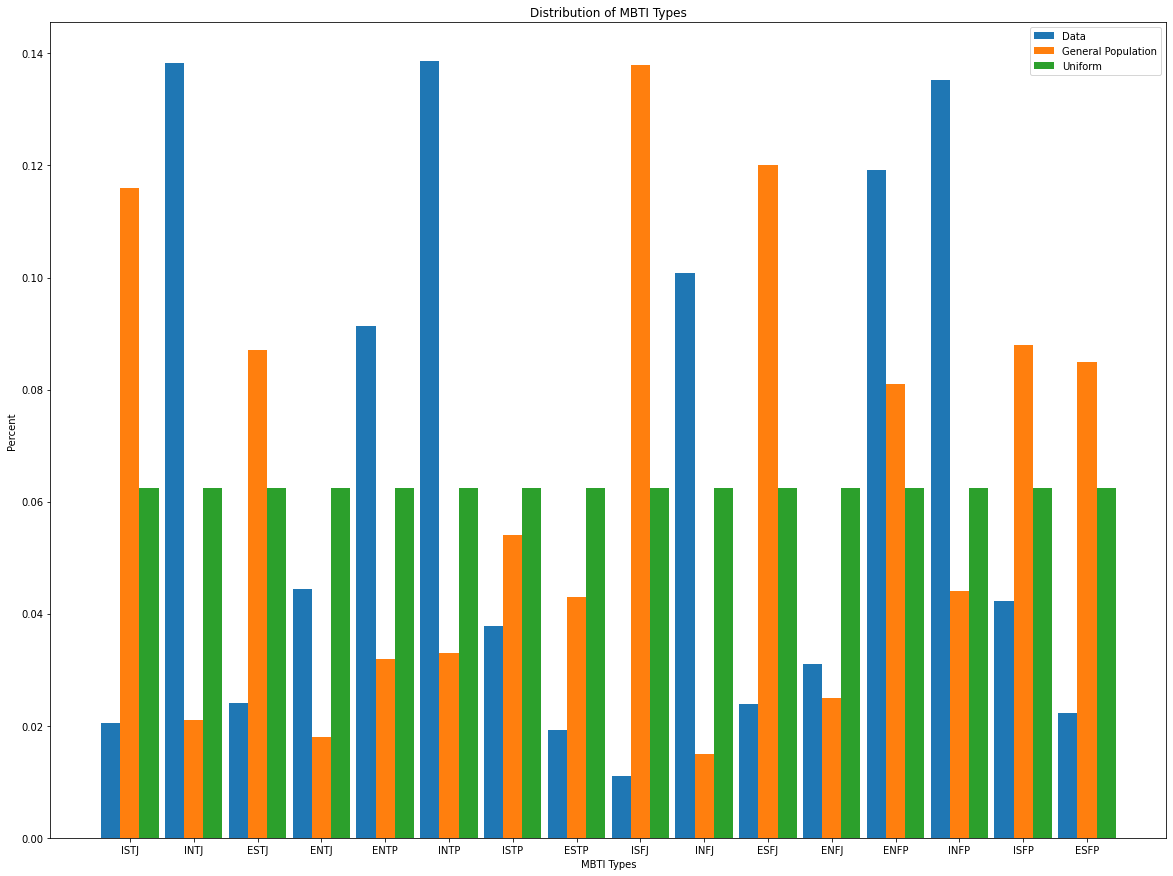

In [55]:
# plot MBTI distributions for data, general population, uniform  

X_axis = np.arange(len(valid_MBTI))  
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)


plt.bar(X_axis - .3, mbti_data_pct, 0.3, label = 'Data')
plt.bar(X_axis + 0, mbti_est_gen_pop_pct, 0.3, label = 'General Population')
plt.bar(X_axis + .3, mbti_uniform_pct, 0.3, label = 'Uniform')
  
plt.xticks(X_axis, valid_MBTI)
plt.xlabel("MBTI Types")
plt.ylabel("Percent")
plt.title("Distribution of MBTI Types")
plt.legend()


plt.show()

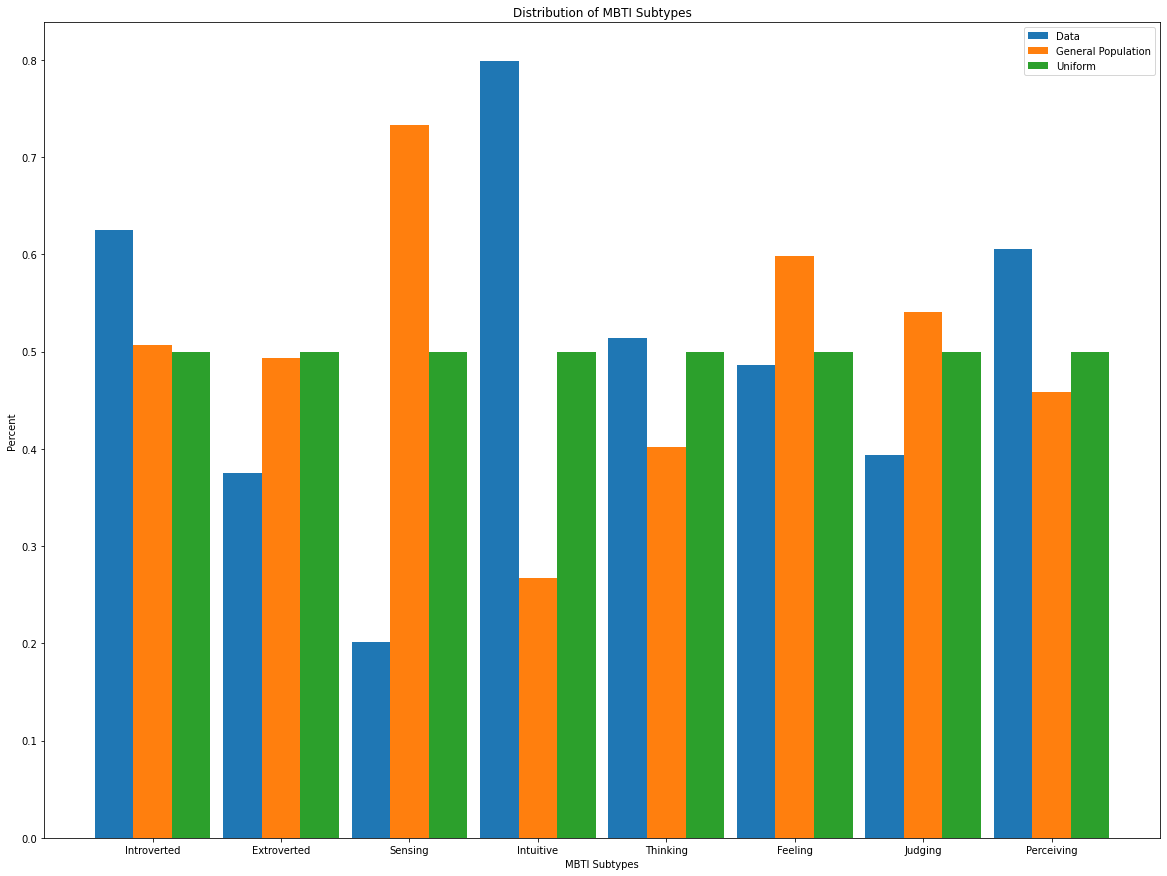

In [56]:
# plot MBTI subtypes distributions for data, general population, uniform  

X_axis = np.arange(len(valid_subtypes))  
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(15)


plt.bar(X_axis - .3, subtypes_data_pct, 0.3, label = 'Data')
plt.bar(X_axis + 0, subtypes_est_gen_pop_pct, 0.3, label = 'General Population')
plt.bar(X_axis + .3, subtypes_uniform_pct, 0.3, label = 'Uniform')
  
plt.xticks(X_axis, valid_subtypes)
plt.xlabel("MBTI Subtypes")
plt.ylabel("Percent")
plt.title("Distribution of MBTI Subtypes")
plt.legend()


plt.show()

In [57]:
# read the Training, Dev and Tests labels in from files
# check that the distribution of categories is relatively the same across train, dev and test sets


# Training
train_y_df = read_parquet_from_gcloud( 'train_mbti_labels.parquet')


train_df= users_sorted_df[:train_test_boundary_sample]

print( "train_df shape:", train_df.shape )
print( "train_df columns:", train_df.columns )
print( "train_y_df", train_y_df.head() )


# Dev
dev_y_df = read_parquet_from_gcloud( 'dev_mbti_labels.parquet')


dev_df = users_sorted_df[test_dev_boundary_sample:total_samples]
print( "dev_df shape:", dev_df.shape )
print( "dev_df columns:", dev_df.columns )
print( "dev_df", dev_y_df.head() )

# Test
test_y_df = read_parquet_from_gcloud( 'test_mbti_labels.parquet')

# put the data back together for analysis
test_df = users_sorted_df[test_dev_boundary_sample:total_samples]

print( "test_df shape:", test_df.shape )
print( "test_df columns:", test_df.columns )
print( "test_y_df", test_y_df.head() )



train_df shape: (1187032, 17)
train_df columns: Index(['original index', 'Username', 'Age', 'Posts', 'MBTI Type', 'Enneagram',
       'Instinctual Variant', 'Gender', 'Occupation', 'is_I', 'is_S', 'is_T',
       'is_J', 'post_id', 'thread_id', 'post_date', 'message'],
      dtype='object')
train_y_df    original index MBTI Type
0          553882      INFP
1          832376      ENFP
2         1427692      ISFP
3         1398882      ISTJ
4           24219      INTP
dev_df shape: (151313, 17)
dev_df columns: Index(['original index', 'Username', 'Age', 'Posts', 'MBTI Type', 'Enneagram',
       'Instinctual Variant', 'Gender', 'Occupation', 'is_I', 'is_S', 'is_T',
       'is_J', 'post_id', 'thread_id', 'post_date', 'message'],
      dtype='object')
dev_df    original index MBTI Type
0          946199      ENTP
1          706403      ENTP
2           45850      ENFP
3         1110301      INTJ
4          470221      INFJ
test_df shape: (151313, 17)
test_df columns: Index(['original index',

In [58]:
# Now do a sanity check of the distribution in the Training, Test and Dev splits of the data

train_type_counts, train_data_pct, train_sub_data_counts, train_sub_data_pct = get_MBTI_distribution( train_df )
dev_type_counts, dev_data_pct, dev_sub_data_counts, dev_sub_data_pct = get_MBTI_distribution( dev_df )
test_type_counts, test_data_pct, test_sub_data_counts, test_sub_data_pct = get_MBTI_distribution( test_df )

total posts in input_df: 1187032
MBTI type counts in input df: INFP    188313
INTJ    187196
INTP    144313
ENFP    128422
ENTP    107980
INFJ    105868
ISFP     60031
ISTP     50192
ENTJ     43445
ENFJ     38697
ESFP     32556
ESTJ     31029
ISTJ     23462
ESTP     20736
ESFJ     12484
ISFJ     12308
Name: MBTI Type, dtype: int64
MBTI type pcts in input df: [0.019765263278496283, 0.1577008875919099, 0.026139986116633755, 0.03659968728728459, 0.09096637664359512, 0.12157465005155717, 0.04228361156228307, 0.017468779274695208, 0.010368717945261795, 0.08918714912487616, 0.010516986905155042, 0.03259979511925542, 0.10818747936028683, 0.15864189002486875, 0.050572351882678813, 0.02742638783116209]
[771683, 415349, 242798, 944234, 608353, 578679, 454489, 732543]
[0.6500945214619319, 0.3499054785380681, 0.20454208479636607, 0.795457915203634, 0.5124992418064551, 0.48750075819354494, 0.38287847336887293, 0.6171215266311271]
total posts in input_df: 151313
MBTI type counts in input df: ENFP   

In [59]:
# plot MBTI distributions for data, general population, uniform  

def plot_MBTI_distribution( title, input_MBTI_pct ):

    X_axis = np.arange(len(valid_MBTI))  
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(15)


    plt.bar(X_axis - .3, input_MBTI_pct, 0.3, label = 'Data')
    plt.bar(X_axis + 0, mbti_est_gen_pop_pct, 0.3, label = 'General Population')
    plt.bar(X_axis + .3, mbti_uniform_pct, 0.3, label = 'Uniform')
    
    plt.xticks(X_axis, valid_MBTI)
    plt.xlabel("MBTI Types")
    plt.ylabel("Percent")
    plt.title(title)
    plt.legend()


    plt.show()

def plot_MBTI_subtypes_distribution( title, input_subtypes_dist ):

    X_axis = np.arange(len(valid_subtypes))  
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(15)


    plt.bar(X_axis - .3, input_subtypes_dist, 0.3, label = 'Data')
    plt.bar(X_axis + 0, subtypes_est_gen_pop_pct, 0.3, label = 'General Population')
    plt.bar(X_axis + .3, subtypes_uniform_pct, 0.3, label = 'Uniform')
    
    plt.xticks(X_axis, valid_subtypes)
    plt.xlabel("MBTI Subtypes")
    plt.ylabel("Percent")
    plt.title(title)
    plt.legend()


    plt.show()

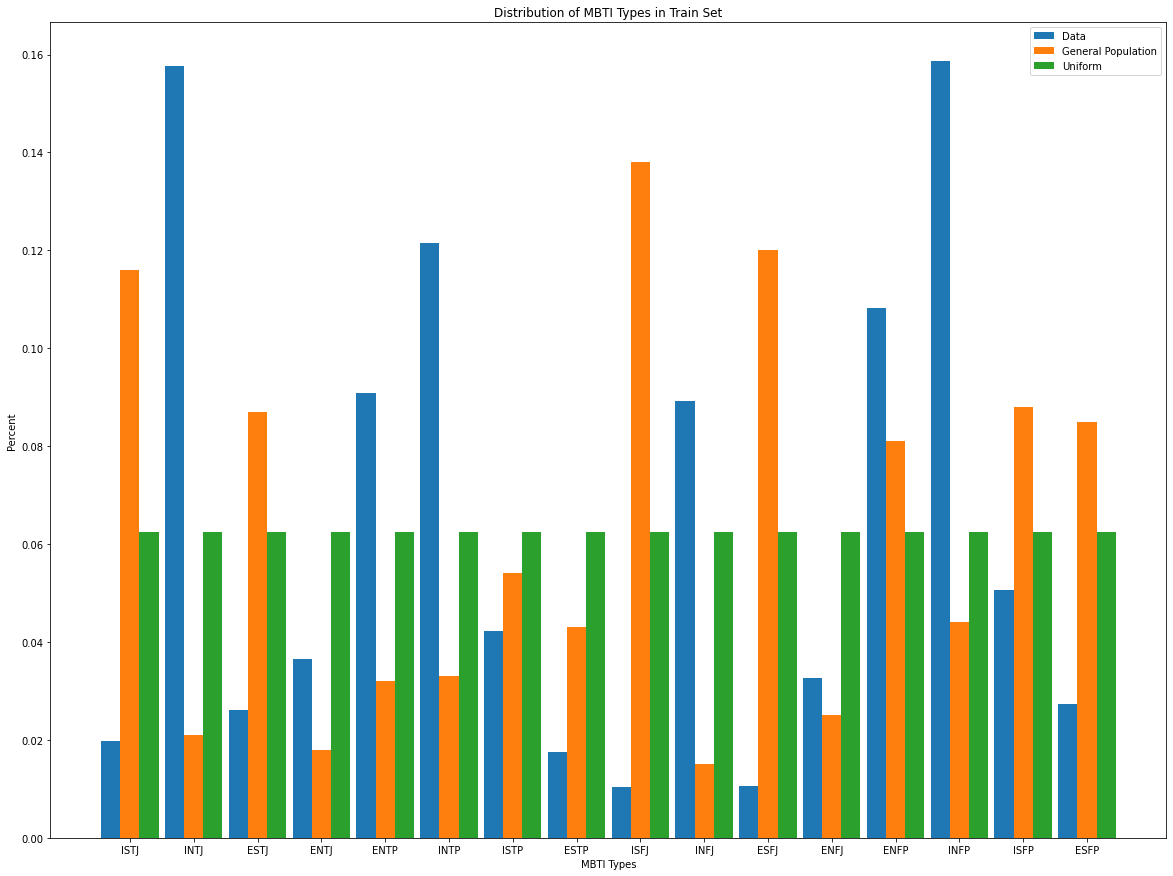

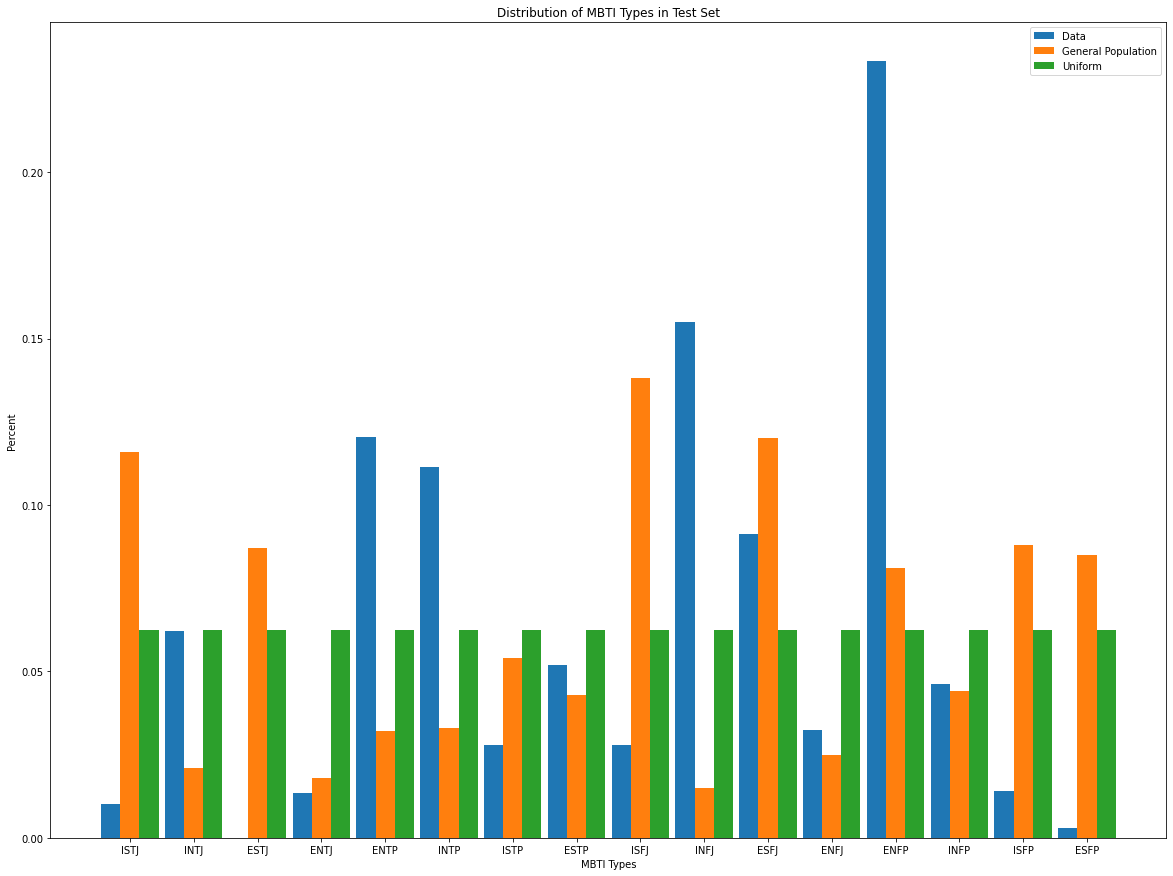

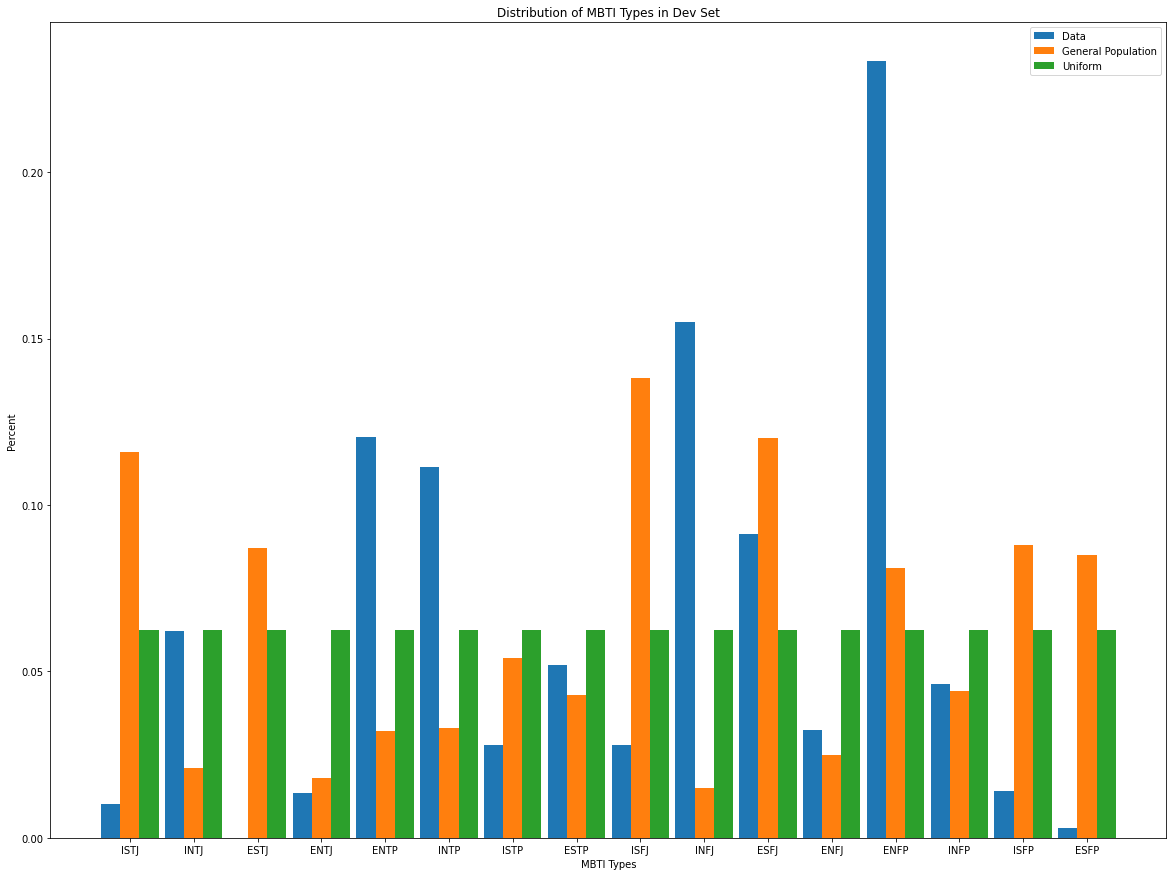

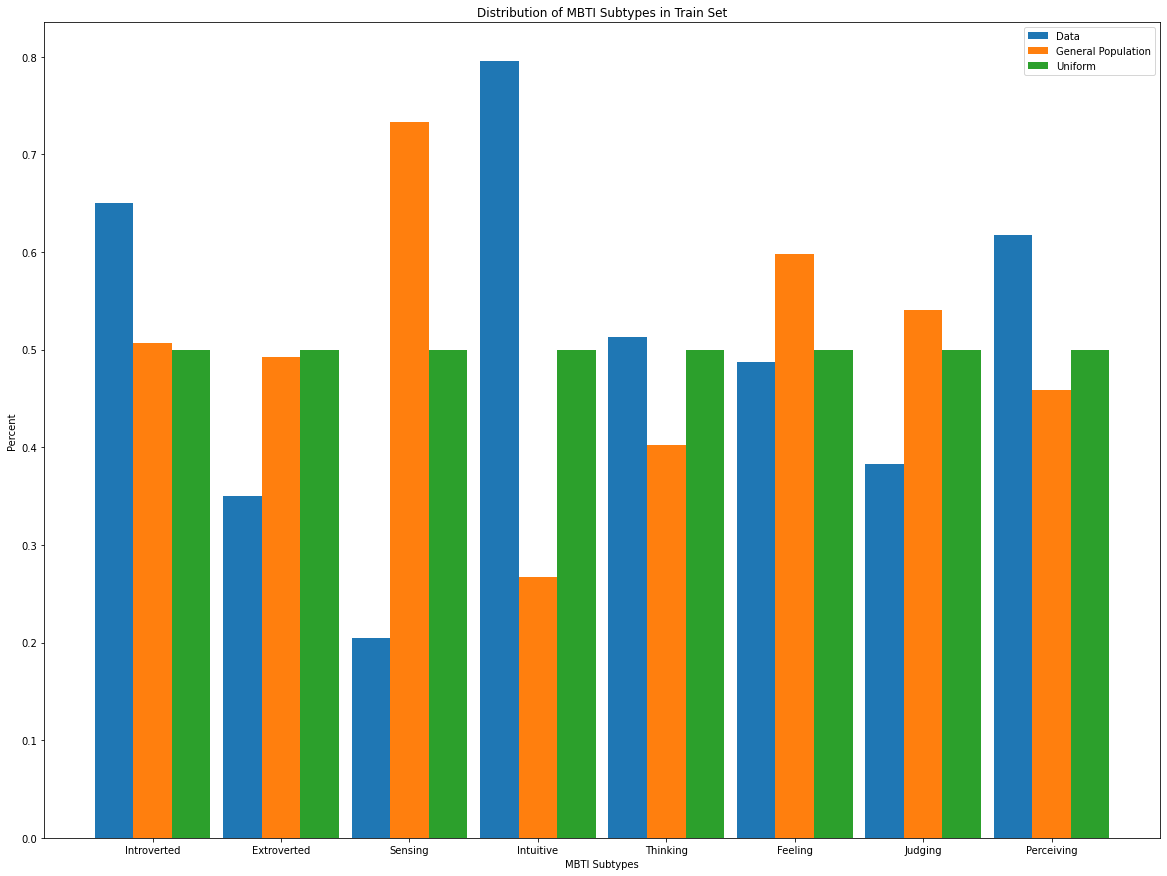

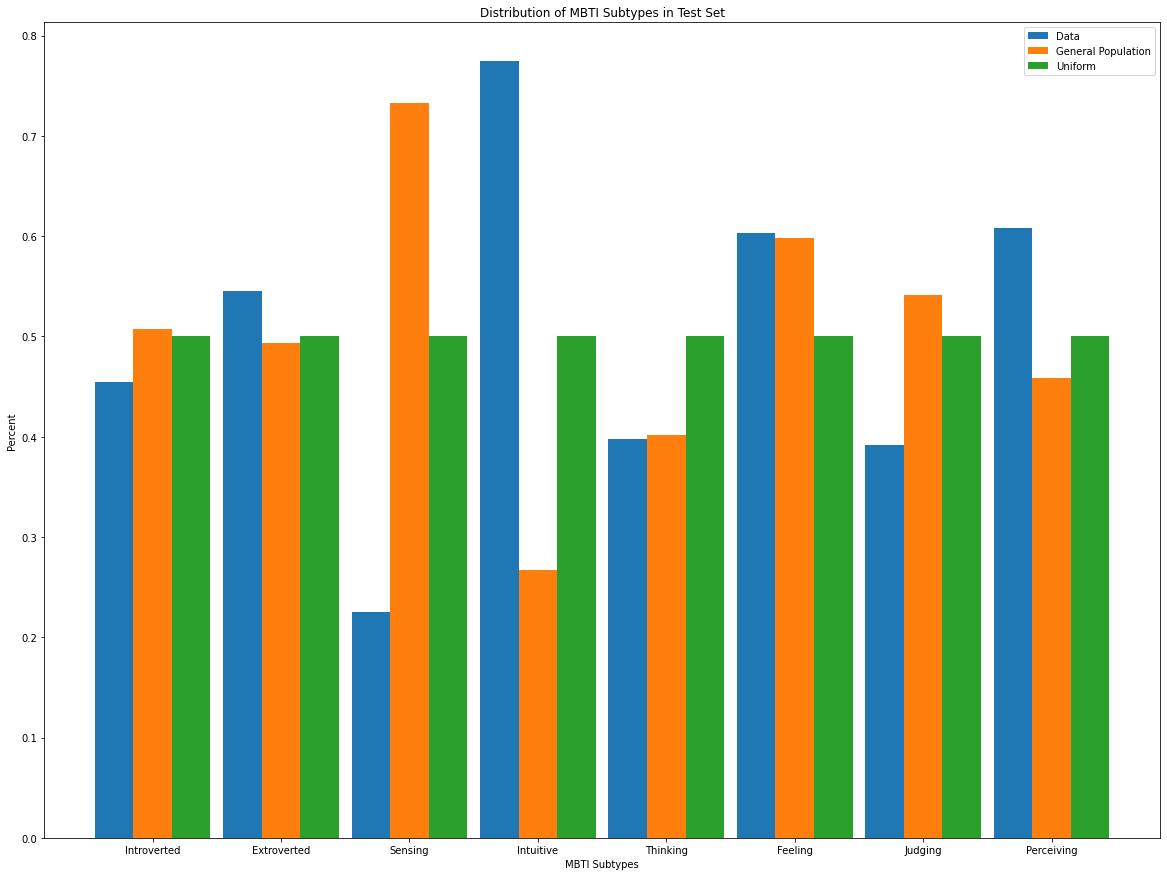

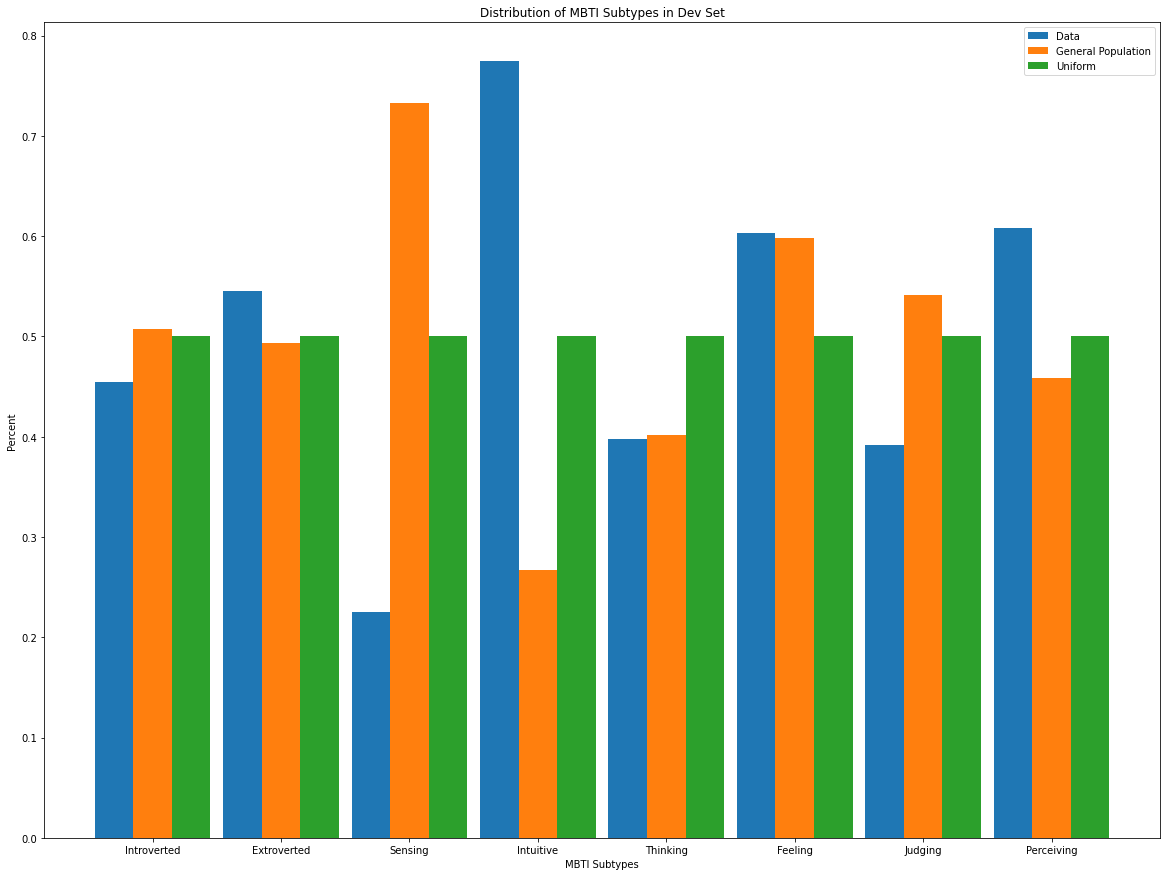

In [60]:
# Let's take a look - we should see the same distribution across the train, test and dev sets

plot_MBTI_distribution( 'Distribution of MBTI Types in Train Set', train_data_pct )
plot_MBTI_distribution( 'Distribution of MBTI Types in Test Set', test_data_pct )
plot_MBTI_distribution( 'Distribution of MBTI Types in Dev Set', dev_data_pct )

plot_MBTI_subtypes_distribution('Distribution of MBTI Subtypes in Train Set', train_sub_data_pct )
plot_MBTI_subtypes_distribution('Distribution of MBTI Subtypes in Test Set', test_sub_data_pct )
plot_MBTI_subtypes_distribution('Distribution of MBTI Subtypes in Dev Set', dev_sub_data_pct )

In [61]:
# Now, resampling

# First, work on uniform distributions which are simpler
# Strategy 1:  Undersampling to uniform
# Strategy 2:  Oversampling to uniform

# Second, match general population distribution
# Strategy 3:  Match general population



resampling_strategy = [ 'uniform_resampling',
                        'match_general_population'
                       ]
     

def is_MBTI_type( column_name ):
    return column_name in valid_MBTI


gen_pop_pcts_by_cat = {
    'ISTJ': .116,
    'INTJ': .021,
    'ESTJ': .087,
    'ENTJ': .018,
    'ENTP': .032,
    'INTP': .033,
    'ISTP': .054,
    'ESTP': .043,
    'ISFJ': .138,
    'INFJ': .015,
    'ESFJ': .120,
    'ENFJ': .025,
    'ENFP': .081,
    'INFP': .044,
    'ISFP': .088,
    'ESFP': .085,
    'Introverted': .507,
    'Extroverted': .493,
    'Sensing': .733,
    'Intuitive': .267,
    'Thinking': .402,
    'Feeling': .598,
    'Judging': .541,
    'Perceiving': .459
}

def get_general_pop_pct( category, column_name = None ):
    if column_name == None:
        if category == True:
            print( "invalid category- also need column name")
            return None
        elif category == False:
            print( "invalid category- also need column name")
            return None
        else:
            return gen_pop_pcts_by_cat[category]
    else:
        if column_name == 'is_I':
            if category == True:
                return gen_pop_pcts_by_cat['Introverted']
            else:
                return gen_pop_pcts_by_cat['Extroverted']
        elif column_name == 'is_S':
            if category == True:
                return gen_pop_pcts_by_cat['Sensing']
            else:
                return gen_pop_pcts_by_cat['Intuitive']
        elif column_name == 'is_T':
            if category == True:
                return gen_pop_pcts_by_cat['Thinking']
            else:
                return gen_pop_pcts_by_cat['Feeling']
        elif column_name == 'is_J':
            if category == True:
                return gen_pop_pcts_by_cat['Judging']
            else:
                return gen_pop_pcts_by_cat['Perceiving']
        else:
            return gen_pop_pcts_by_cat[category]


 

In [62]:

def resample_MBTI_data( input_df, column_name, strategy ):

    input_n_samps = input_df.shape[0]
    input_counts = input_df[column_name].value_counts()
    print( "input counts:", input_counts )
    n_categories = len(input_counts)
    categories_list = input_counts.index
    print( "input categories:", categories_list)
    min_count = min(input_counts)
    max_count = max(input_counts)

    uniform_count = int(input_n_samps/n_categories)

    categories_dfs = {}

    for cat in categories_list:
        cat_df = input_df.loc[input_df[column_name] == cat]
        print( cat_df.shape )
        categories_dfs[cat] = cat_df

    # figure out distribution across categories based on strategy
    target_counts_by_cat = {}

    if strategy == 'uniform_resampling':
        # find the category or categories with minimum count and reduce all the other categories to the same count
        target_counts = [uniform_count for cat in categories_list ]
        target_counts_by_cat = dict(zip(categories_list, target_counts))
        print( "target_counts_by_cat:", target_counts_by_cat )

    else:
        # for the general population distribution, either over or under sampling means applying the distribution to the counts of the input_df
        # convert distribution to counts array based on the overall size

        for cat in categories_list:
            print( "Category:", cat )
            cat_pct = get_general_pop_pct(cat, column_name)
            print( "cat_pct:", cat_pct )
            if cat_pct == None:
                print( "Error retrieving target percent for category", cat, column_name )
            cat_count = int(input_n_samps*cat_pct)
            print( "Category count:", cat_count)
            target_counts_by_cat[cat] = cat_count


    # now do the resampling to the count in the target_counts_by_cat array for each category
    resampled_dfs = {}

    for cat in categories_list:
        cat_in_df = categories_dfs[cat]
        cat_out_count = target_counts_by_cat[cat]
        print( "Category count:", cat_out_count)
        cat_out_df = resample(cat_in_df, replace=True, n_samples = cat_out_count, random_state = 42)
        resampled_dfs[cat] = cat_out_df

    output_df = pd.concat(list(resampled_dfs.values()))

    # shuffle the samples so that they are not sorted by category
    output_df = output_df.sample(frac=1, random_state = 42).reset_index()

    # check what we did
    # for df in resampled_dfs.values():
    #     print( "Df shape:", df.shape)

    # print( "output_df shape:", output_df.shape)
    return output_df


 


In [63]:
# Let's do some resampling of the training data

# uniform under sampling MBTI
uniform_MBTI_df = resample_MBTI_data( train_df, 'MBTI Type', 'uniform_resampling')

y_uniform_df = uniform_MBTI_df[['original index', 'MBTI Type']]
X_uniform_df = uniform_MBTI_df.drop(labels = ['MBTI Type'], axis = 1)

print( "uniform shape:", uniform_MBTI_df.shape )
print( "uniform columns:", uniform_MBTI_df.columns )
print( "uniform X shape:", X_uniform_df.shape )
print( "uniform X columns:", X_uniform_df.columns )
print( "uniform y shape:", y_uniform_df.columns )

print( "uniform data:", X_uniform_df.head() )
print( "uniform labels:", y_uniform_df.head() )

# match gen pop MBTI
gen_pop_dist_MBTI_df = resample_MBTI_data( train_df, 'MBTI Type', 'match_general_population')

y_genpop_df = gen_pop_dist_MBTI_df[['original index', 'MBTI Type']]
X_genpop_df = gen_pop_dist_MBTI_df.drop(labels = ['MBTI Type'], axis = 1)

print( "genpop shape:", gen_pop_dist_MBTI_df.shape )
print( "genpop columns:", gen_pop_dist_MBTI_df.columns )
print( "genpop X shape:", X_genpop_df.shape )
print( "genpop X columns:", X_genpop_df.columns )
print( "genpop y shape:", y_genpop_df.columns )

print( "genpop data:", X_genpop_df.head() )
print( "genpop labels:", y_genpop_df.head() )


input counts: INFP    188313
INTJ    187196
INTP    144313
ENFP    128422
ENTP    107980
INFJ    105868
ISFP     60031
ISTP     50192
ENTJ     43445
ENFJ     38697
ESFP     32556
ESTJ     31029
ISTJ     23462
ESTP     20736
ESFJ     12484
ISFJ     12308
Name: MBTI Type, dtype: int64
input categories: Index(['INFP', 'INTJ', 'INTP', 'ENFP', 'ENTP', 'INFJ', 'ISFP', 'ISTP', 'ENTJ',
       'ENFJ', 'ESFP', 'ESTJ', 'ISTJ', 'ESTP', 'ESFJ', 'ISFJ'],
      dtype='object')
(188313, 17)
(187196, 17)
(144313, 17)
(128422, 17)
(107980, 17)
(105868, 17)
(60031, 17)
(50192, 17)
(43445, 17)
(38697, 17)
(32556, 17)
(31029, 17)
(23462, 17)
(20736, 17)
(12484, 17)
(12308, 17)
target_counts_by_cat: {'INFP': 74189, 'INTJ': 74189, 'INTP': 74189, 'ENFP': 74189, 'ENTP': 74189, 'INFJ': 74189, 'ISFP': 74189, 'ISTP': 74189, 'ENTJ': 74189, 'ENFJ': 74189, 'ESFP': 74189, 'ESTJ': 74189, 'ISTJ': 74189, 'ESTP': 74189, 'ESFJ': 74189, 'ISFJ': 74189}
Category count: 74189
Category count: 74189
Category count: 74189
Catego

total posts in input_df: 1187024
MBTI type counts in input df: ENTJ    74189
ENFJ    74189
ESTJ    74189
INFJ    74189
INFP    74189
ENTP    74189
ESFJ    74189
ESFP    74189
ESTP    74189
ENFP    74189
ISFJ    74189
ISTJ    74189
ISFP    74189
INTJ    74189
INTP    74189
ISTP    74189
Name: MBTI Type, dtype: int64
MBTI type pcts in input df: [0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]
[593512, 593512, 593512, 593512, 593512, 593512, 593512, 593512]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Distribution of resampled training data to match uniform distribution:


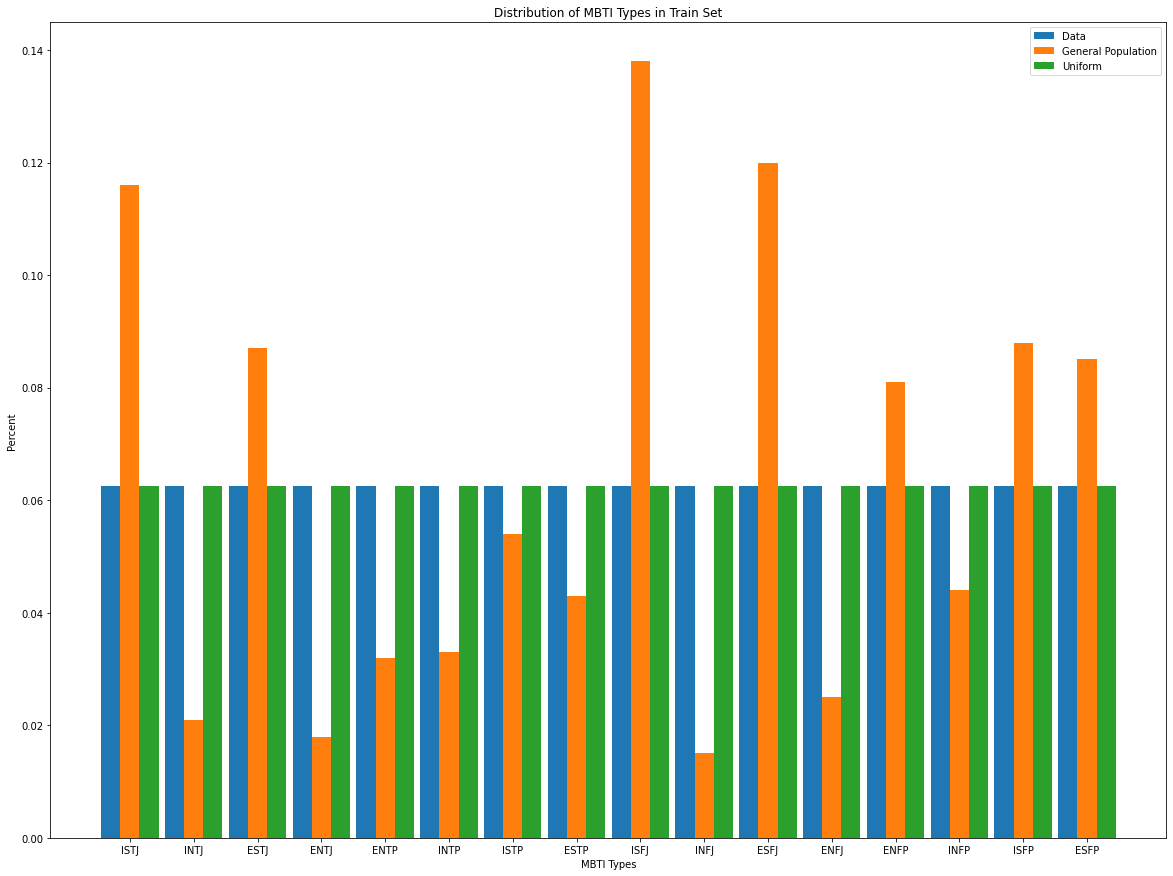

total posts in input_df: 1187023
MBTI type counts in input df: ISFJ    163810
ESFJ    142443
ISTJ    137695
ISFP    104458
ESTJ    103271
ESFP    100897
ENFP     96149
ISTP     64099
INFP     52229
ESTP     51042
INTP     39172
ENTP     37985
ENFJ     29675
INTJ     24927
ENTJ     21366
INFJ     17805
Name: MBTI Type, dtype: int64
MBTI type pcts in input df: [0.11600027969129495, 0.020999593099712475, 0.08699999915755634, 0.01799965122832498, 0.0320002224051261, 0.03300020302892193, 0.053999796128634404, 0.04300000926688025, 0.13800069585846272, 0.014999709356937481, 0.12000020218647828, 0.024999515594895803, 0.08100011541478135, 0.043999989890676085, 0.08799997978135217, 0.08500003790996467]
[604195, 582828, 867715, 319308, 479557, 707466, 640992, 546031]
[0.5090002468359922, 0.4909997531640078, 0.7310009999806238, 0.2689990000193762, 0.40399975400645144, 0.5960002459935486, 0.539999646173663, 0.46000035382633697]
Distribution of resampled training data to match general population dis

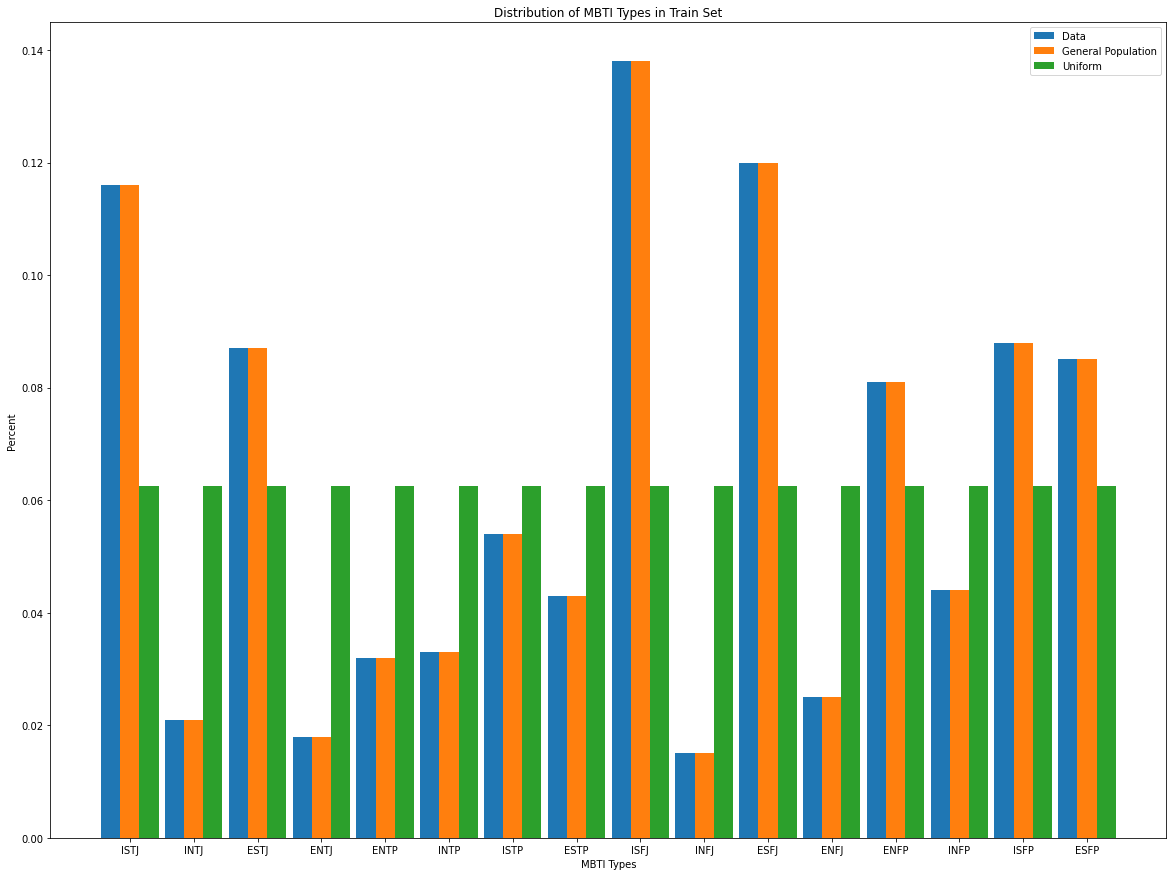

In [64]:
# Just take a look at what we got from resampling

uniform_type_counts, uniform_data_pct, uniform_sub_data_counts, uniform_sub_data_pct = get_MBTI_distribution( uniform_MBTI_df )

print( "Distribution of resampled training data to match uniform distribution:")
plot_MBTI_distribution( 'Distribution of MBTI Types in Train Set', uniform_data_pct )

genpop_type_counts, genpop_data_pct, genpop_sub_data_counts, genpop_sub_data_pct = get_MBTI_distribution( gen_pop_dist_MBTI_df )

print( "Distribution of resampled training data to match general population distribution:")
plot_MBTI_distribution( 'Distribution of MBTI Types in Train Set', genpop_data_pct )



In [65]:
# Let's write out different resampled versions of training data and labels
write_parquet_file(X_uniform_df, 'train_uniform_mbti_data.parquet')
write_parquet_file(y_uniform_df, 'train_uniform_mbti_labels.parquet')

write_parquet_file(X_genpop_df, 'train_gen_pop_mbti_data.parquet')
write_parquet_file(y_genpop_df, 'train_gen_pop_mbti_labels.parquet')



In [66]:
# Create resampled sets by subtypes

# Let's do some resampling of the training data for sub type categories

# Introvert/Extrovert
# uniform under sampling MBTI 
uniform_I_df = resample_MBTI_data( train_df, 'is_I', 'uniform_resampling')

y_uniform_df = uniform_I_df[['original index', 'is_I']]
X_uniform_df = uniform_I_df.drop(labels = ['is_I'], axis = 1)

# match gen pop MBTI
gen_pop_dist_MBTI_df = resample_MBTI_data( train_df, 'is_I', 'match_general_population')

y_genpop_df = gen_pop_dist_MBTI_df[['original index', 'is_I']]
X_genpop_df = gen_pop_dist_MBTI_df.drop(labels = ['is_I'], axis = 1)


write_parquet_file(X_uniform_df, 'train_uniform_is_I_data.parquet')
write_parquet_file(y_uniform_df, 'train_uniform_is_I_labels.parquet')
write_parquet_file(X_genpop_df, 'train_gen_pop_is_I_data.parquet')
write_parquet_file(y_genpop_df, 'train_gen_pop_is_I_labels.parquet')


# Sensing/Intuitive
# uniform under sampling MBTI
uniform_I_df = resample_MBTI_data( train_df, 'is_S', 'uniform_resampling')

y_uniform_df = uniform_I_df[['original index', 'is_S']]
X_uniform_df = uniform_I_df.drop(labels = ['is_S'], axis = 1)

# match gen pop MBTI
gen_pop_dist_MBTI_df = resample_MBTI_data( train_df, 'is_S', 'match_general_population')

y_genpop_df = gen_pop_dist_MBTI_df[['original index', 'is_S']]
X_genpop_df = gen_pop_dist_MBTI_df.drop(labels = ['is_S'], axis = 1)


write_parquet_file(X_uniform_df, 'train_uniform_is_S_data.parquet')
write_parquet_file(y_uniform_df, 'train_uniform_is_S_labels.parquet')
write_parquet_file(X_genpop_df, 'train_gen_pop_is_S_data.parquet')
write_parquet_file(y_genpop_df, 'train_gen_pop_is_S_labels.parquet')


# Thinking/Feeling
# uniform under sampling MBTI
uniform_I_df = resample_MBTI_data( train_df, 'is_T', 'uniform_resampling')

y_uniform_df = uniform_I_df[['original index', 'is_T']]
X_uniform_df = uniform_I_df.drop(labels = ['is_T'], axis = 1)

# match gen pop MBTI
gen_pop_dist_MBTI_df = resample_MBTI_data( train_df, 'is_T', 'match_general_population')

y_genpop_df = gen_pop_dist_MBTI_df[['original index', 'is_T']]
X_genpop_df = gen_pop_dist_MBTI_df.drop(labels = ['is_T'], axis = 1)


write_parquet_file(X_uniform_df, 'train_uniform_is_T_data.parquet')
write_parquet_file(y_uniform_df, 'train_uniform_is_T_labels.parquet')
write_parquet_file(X_genpop_df, 'train_gen_pop_is_T_data.parquet')
write_parquet_file(y_genpop_df, 'train_gen_pop_is_T_labels.parquet')


# Judging/Perceiving
# uniform under sampling MBTI
uniform_I_df = resample_MBTI_data( train_df, 'is_J', 'uniform_resampling')

y_uniform_df = uniform_I_df[['original index', 'is_J']]
X_uniform_df = uniform_I_df.drop(labels = ['is_J'], axis = 1)

# match gen pop MBTI
gen_pop_dist_MBTI_df = resample_MBTI_data( train_df, 'is_J', 'match_general_population')

y_genpop_df = gen_pop_dist_MBTI_df[['original index', 'is_J']]
X_genpop_df = gen_pop_dist_MBTI_df.drop(labels = ['is_J'], axis = 1)


write_parquet_file(X_uniform_df, 'train_uniform_is_J_data.parquet')
write_parquet_file(y_uniform_df, 'train_uniform_is_J_labels.parquet')
write_parquet_file(X_genpop_df, 'train_gen_pop_is_J_data.parquet')
write_parquet_file(y_genpop_df, 'train_gen_pop_is_J_labels.parquet')





input counts: True     771683
False    415349
Name: is_I, dtype: int64
input categories: Index([True, False], dtype='object')
(771683, 17)
(415349, 17)
target_counts_by_cat: {True: 593516, False: 593516}
Category count: 593516
Category count: 593516
input counts: True     771683
False    415349
Name: is_I, dtype: int64
input categories: Index([True, False], dtype='object')
(771683, 17)
(415349, 17)
Category: True
cat_pct: 0.507
Category count: 601825
Category: False
cat_pct: 0.493
Category count: 585206
Category count: 601825
Category count: 585206
input counts: False    944234
True     242798
Name: is_S, dtype: int64
input categories: Index([False, True], dtype='object')
(944234, 17)
(242798, 17)
target_counts_by_cat: {False: 593516, True: 593516}
Category count: 593516
Category count: 593516
input counts: False    944234
True     242798
Name: is_S, dtype: int64
input categories: Index([False, True], dtype='object')
(944234, 17)
(242798, 17)
Category: False
cat_pct: 0.267
Category cou